In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

import helper

In [ ]:
data_dir = '/content/drive/My Drive/ROCK_VISION/ROCK AI/'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       ])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                     ])

In [ ]:
train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)

test_data = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

In [ ]:
def process_image(image_path):
  img = Image.open(image_path)

  width, height = img.size
  print(img.size)

  img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))

  width, height = img.size
  print(img.size)

  left = (width - 224)/2
  top = (height - 224)/2
  right = (width + 224)/2
  bottom = (height + 224)/2
  img = img.crop((left, top, right, bottom))
    
  # Turn image into numpy array
  img = np.array(img)
  #print(img)
  print(type(img))

  # Make the color channel dimension first instead of last
  img = img.transpose((2, 0, 1))
  print(type(img))

  # Make all values between 0 and 1
  img = img/255
    
  # Normalize based on the preset mean and standard deviation
  img[0] = (img[0] - 0.485)/0.229
  img[1] = (img[1] - 0.456)/0.224
  img[2] = (img[2] - 0.406)/0.225
    
  # Add a fourth dimension to the beginning to indicate batch size
  img = img[np.newaxis,:]
    
  # Turn into a torch tensor
  image = torch.from_numpy(img)
  image = image.float()
  print(f'Image shape: {image.shape}')
  return image

In [ ]:
def predict(image, model):

  model.eval()
  
  with torch.no_grad():
    output = model.forward(image)

  output = torch.exp(output)
  probs, classes = output.topk(1, dim=1)
  
  return probs.item(), classes.item()

def show_image(image):

  image = image.numpy()

  image[0] = image[0] * 0.226 + 0.445

  fig = plt.figure(figsize=(25,4))

  plt.imshow(np.transpose(image[0], (1,2,0)))

In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [ ]:
model = models.densenet121(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 14),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

In [ ]:
epochs = 25
steps = 0
running_loss = 0
print_every = 5
train_losses, test_losses = [], []

for epoch in range(epochs):
  running_loss = 0
  for inputs, labels in trainloader:
    steps += 1
        
    optimizer.zero_grad()
        
    #inputs.resize_(inputs.shape[0], -1)
    logps = model.forward(inputs)
    loss = criterion(logps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    if True:
      test_loss = 0
      accuracy = 0
      model.eval()
            
      with torch.no_grad():
        for inputs, labels in testloader:
          #inputs.resize_(inputs.shape[0], -1)
          logps = model.forward(inputs)
          batch_loss = criterion(logps, labels)
                  
          test_loss += batch_loss.item()
                  
          # Calculate accuracy
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {running_loss/print_every:.3f}.. "
              f"Test loss: {test_loss/len(testloader):.3f}.. "
              f"Test accuracy: {accuracy/len(testloader):.3f}")
        running_loss = 0
        model.train()

Epoch 1/25.. Train loss: 0.086.. Test loss: 0.225.. Test accuracy: 0.929
Epoch 1/25.. Train loss: 0.059.. Test loss: 0.217.. Test accuracy: 0.964
Epoch 1/25.. Train loss: 0.085.. Test loss: 0.246.. Test accuracy: 0.964
Epoch 1/25.. Train loss: 0.056.. Test loss: 0.263.. Test accuracy: 0.964
Epoch 2/25.. Train loss: 0.071.. Test loss: 0.249.. Test accuracy: 0.964
Epoch 2/25.. Train loss: 0.062.. Test loss: 0.209.. Test accuracy: 0.964
Epoch 2/25.. Train loss: 0.046.. Test loss: 0.163.. Test accuracy: 0.964
Epoch 2/25.. Train loss: 0.047.. Test loss: 0.151.. Test accuracy: 1.000
Epoch 3/25.. Train loss: 0.057.. Test loss: 0.170.. Test accuracy: 0.929
Epoch 3/25.. Train loss: 0.029.. Test loss: 0.207.. Test accuracy: 0.929
Epoch 3/25.. Train loss: 0.076.. Test loss: 0.215.. Test accuracy: 0.929
Epoch 3/25.. Train loss: 0.084.. Test loss: 0.185.. Test accuracy: 0.929
Epoch 4/25.. Train loss: 0.045.. Test loss: 0.158.. Test accuracy: 0.964
Epoch 4/25.. Train loss: 0.053.. Test loss: 0.144..

In [ ]:

img1 = process_image('/content/drive/My Drive/ROCK_VISION/ROCK AI/test/MARBLE/test_marb_1.jpg')

(3000, 4000)
(255, 340)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image shape: torch.Size([1, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


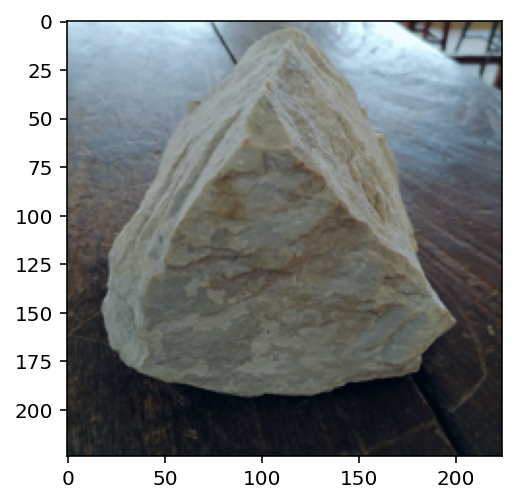

In [ ]:
show_image(img1)

In [ ]:
top_prob, top_class = predict(img1, model)

In [ ]:
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

The model is  96.03363275527954 % certain that the image has a predicted class of  2


(3136, 3136)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(255, 255)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image shape: torch.Size([1, 3, 224, 224])


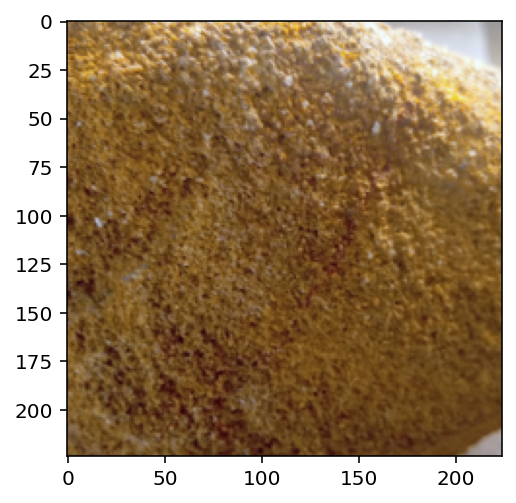

In [ ]:
img1 = process_image('/content/drive/My Drive/ROCK_VISION/ROCK AI/test/sandstone/test_sand_1.jpg')
show_image(img1)

In [ ]:
top_prob, top_class = predict(img1, model)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

The model is  80.88199496269226 % certain that the image has a predicted class of  12


(3136, 3136)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(255, 255)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image shape: torch.Size([1, 3, 224, 224])


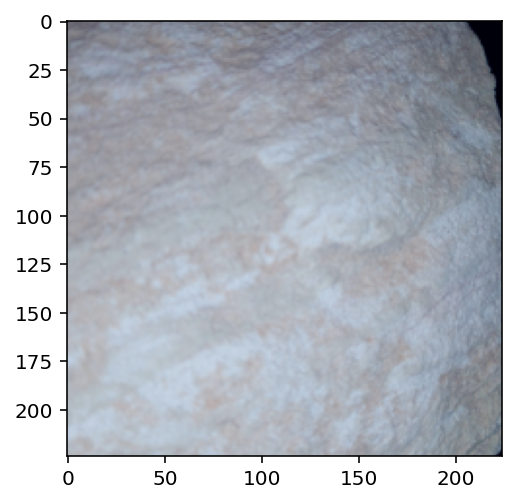

In [ ]:
img3 = process_image('/content/drive/My Drive/ROCK_VISION/ROCK AI/test1/test_clayey_3.jpg')
show_image(img3)

In [ ]:
top_prob, top_class = predict(img1, model)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

The model is  80.88199496269226 % certain that the image has a predicted class of  12


(3136, 3136)
(255, 255)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Image shape: torch.Size([1, 3, 224, 224])


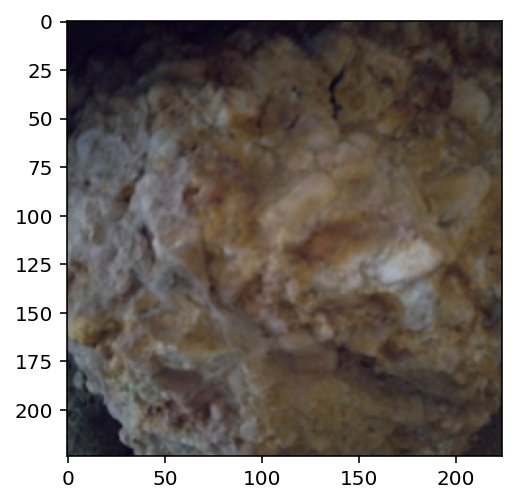

In [ ]:
img2 = process_image('/content/drive/My Drive/ROCK_VISION/ROCK AI/test1/test_fero_4.jpg')
show_image(img2)

In [ ]:
top_prob, top_class = predict(img2, model)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

The model is  50.59715509414673 % certain that the image has a predicted class of  10


In [ ]:
def predict_probs(image, model):

  model.eval()
  
  with torch.no_grad():
    output = model.forward(image)

  output = torch.exp(output)
  probs, classes = output.topk(3, dim=1)
  
  return probs, classes

In [ ]:
top_prob, top_class = predict_probs(img2, model)
# Print the results
print(top_prob, top_class)

tensor([[0.5060, 0.2525, 0.1859]]) tensor([[10,  5,  7]])


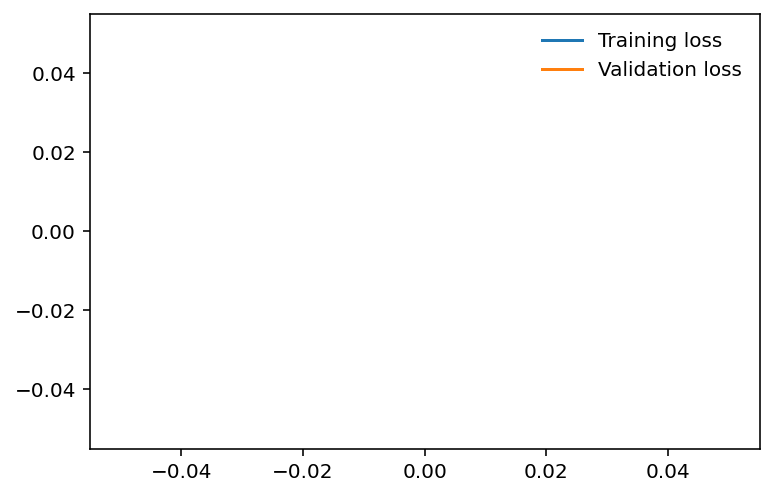

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)